## run a field-level IMNN on simulations with noise

In [1]:
import os

# change JAX GPU memory preallocation fraction
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from jax import config
config.update("jax_enable_x64", False)

%load_ext autoreload
%autoreload 2

import jax

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla V100-PCIE-32GB


In [2]:
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla V100-PCIE-32GB


In [3]:
cd ~/repositories/wl-sbi/imnn_scripts/

/home/makinen/repositories/wl-sbi/imnn_scripts


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *
from imnn_update import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### pull in simulations and compute MOPED for Cls WITH NOISE

In [5]:
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

L = 250 #250
N = 192
cl_cut = -1 #14 #13 #6 # 13
skip = 12 #2

OUTBINS = 6
num_bins = OUTBINS
num_tomo = 4
Lgrid = (L, L, 4000)
Nmesh = (N, N, 512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))
cl_shape = indices.shape[0] * OUTBINS

# NO NOISE FOR NOW
NOISEAMP = 1./8.


do_noise = True

def compute_variance_catalog(zmean=z_means_analysis):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 #/ 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = 30. / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([0.00101297, 0.00196814, 0.00303132, 0.00412674], dtype=float32)

In [6]:
#@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

#@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [7]:
from typing import Tuple

@jax.jit
def compute_auto_cross_angular_power_spectrum(
    field1: jnp.ndarray,
    field2: jnp.ndarray,
    distance: float,
    size: float,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute the auto or cross angular power spectrum of 2D arrays of data.

    Parameters:
        - field1 (jnp.ndarray): first 2D data field with shape (N, N).
        - field2 (jnp.ndarray): second 2D data field with shape (N, N). If the same field
            is provided, the auto- angular power spectrum is computed.
        - distance (float): Comoving distance to the plane.
        - size (float): Size of the patch in Mpc/h.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray]: A tuple containing the filtered angular modes (ell) and
        the angular power spectrum values (Cl).

    """
    # Mesh properties
    Nx, Ny = field1.shape
    Npix = Nx * Ny

    # Fourier transform of the field
    field1_ft = jnp.fft.fftn(field1)
    field2_ft = jnp.fft.fftn(field2)


    # Angular size of the patch
    theta = size / distance

    # Fundamental angular mode
    ell_fundamental = 2.0 * jnp.pi / theta

    # Unbinned power spectrum. Mix the two fields.
    power_2D = field1_ft
    power_2D = power_2D.at[...].mul(jnp.conj(field2_ft))
    power_2D = power_2D.at[...].set(jnp.abs(power_2D).astype(jnp.float32) / Npix**2.)
    power_2D = power_2D.astype(jnp.float32)
    #power_2D = jnp.abs(field1_ft * jnp.conj(field2_ft)) / Npix**2.

    # Fourier modes of the box
    kx = jnp.fft.fftfreq(Nx, d=1.0) * Nx
    ky = jnp.fft.fftfreq(Ny, d=1.0) * Ny
    kx = kx[:, None]
    ky = ky[None, :]
    k_modes = jnp.sqrt(kx**2 + ky**2)

    # Angular modes
    ell_vals = (k_modes * ell_fundamental).flatten()

    # Binned power spectrum
    ell_bins = jnp.arange(0.5, Ny // 2 + 1, 1.0) * ell_fundamental
    ell = 0.5 * (ell_bins[1:] + ell_bins[:-1])
    power = power_2D.flatten()
    binned_power, _ = jnp.histogram(ell_vals, weights=power, bins=ell_bins)
    mode_counts, _ = jnp.histogram(ell_vals, bins=ell_bins)

    # Normalize the binned power spectrum
    Cl = (binned_power / mode_counts) * theta**2

    return ell, Cl

In [8]:
from functools import partial
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *

import netket as nk
from jax import config
config.update("jax_enable_x64", False)


    

def cls_allbins(tomo_data, key, chunk_size=10):

    def get_spec(index, tomo_data, key):
        if do_noise:
            tomo_data = noise_simulator(key, tomo_data)
        ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                    chi_source, Lgrid[0])
    
        return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]
    gps = partial(get_spec, tomo_data=tomo_data, key=key)
    return nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)





def cls_allbins_nonoise(tomo_data, chunk_size=2):
    def get_spec_nonoise(index, tomo_data):
        ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])
        return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]
    gps = partial(get_spec_nonoise, tomo_data=tomo_data)
    return nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)


In [9]:
num_bins = OUTBINS

In [10]:
num_bins

6

In [11]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.5, 1.162]) #jnp.array([0.5, 0.67])
θ_fid = jnp.array([0.3, 0.8])
δθ = 2*jnp.array([0.0115, 0.01]) # BIG DERV STEP

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 750 // 2 #125

n_params = 2
n_summaries = n_params
print(θ_der)

L = Lgrid[0]
lpt_order = 2



[[0.2885 0.8   ]
 [0.3    0.79  ]
 [0.3115 0.8   ]
 [0.3    0.81  ]]


# NPE code

In [12]:
from NPE import npe
from NPE.multipole_cnn import MultipoleConv
from NPE.multipole_cnn_factory import MultipoleCNNFactory

## network code

In [13]:
# load mdn thing
from typing import Sequence, Callable
import jax
from jax.scipy.special import logsumexp # Compute the log of the sum of exponentials of input elements
from jax.nn import softmax # pretty much the same as the interface as the one in scipy.special

import flax.linen as nn

np = jnp

import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


class MLP(nn.Module):
  features: Sequence[int]
  act: nn.activation = nn.tanh

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


In [14]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp

Array = Any

@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding_pow2(arraylen):
    """
    helper function to pad uneven strided outputs
    """
    
    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)

def get_padding(arraylen, padto):
    """
    helper function to pad uneven strided outputs
    """
    
    #next_power = next_power_of_two(arraylen)
    deficit = int(padto - arraylen + 1) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = almost_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):

        d = self.dim
            
        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim, 
                     strides=(2,)*d if d == 2 else (2,2,1), 
                     padding="CIRCULAR", dtype=self.dtype)(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(z)
        x2 = self.act(x2 + z)

        # 2x2 stride with pool
        # x2p = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, 
        #               strides=(2,)*d if d == 2 else (2,2,1), 
        #               padding="CIRCULAR")(x)
        # x2p = self.act(x2p)
        # x2p = nn.max_pool(x2p, (4,4), strides=None, padding="SAME")
        

        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                     strides=(3,)*d if d == 2 else (3,3,1), 
                     padding="CIRCULAR", dtype=self.dtype)(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                         strides=(4,)*d if d == 2 else (4,4,1), 
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(z)
            x4 = self.act(x4 + z)

        
        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape, x2.shape[0])
        
        x3 = jnp.pad(x3, 
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)), 
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(x2)
        x2 = self.act(x2)
        

        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



In [15]:
# TODO: should we make this layer a residual layer ?

class MPK_layer(nn.Module):
    multipole_layers: Sequence[MultipoleConv]
    act: Callable = almost_leaky

    @nn.compact
    def __call__(self, x):
        for i,l in enumerate(self.multipole_layers):
            z = l(x)
            x = self.act(z) if i == 0 else self.act(x + z)
        return x
        
# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)

class MDN_net_stacked(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    #mlp_features: Sequence[int]
    multipole_tomo1: MPK_layer
    moped: MOPED
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = nn.swish
    dtype: Any = jnp.bfloat16
    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x.astype(self.dtype))).reshape(-1, cl_shape)
        cls_summs = self.moped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress

        # pass to trained mdn layer
        #mdn_summs = (get_summaries_mdn(jax.lax.stop_gradient(x)))


        
        # try clipping the field
        # xlog = (log_transform(x) * scale_data).transpose((1, 2, 0))
        # xclip = (clip_transform(x) * scale_data).transpose((1, 2, 0))

        # xlog = cls_allbins_nonoise(jax.lax.stop_gradient(xlog)).reshape(-1)
        # xclip = cls_allbins_nonoise(jax.lax.stop_gradient(xclip)).reshape(-1)

        #x *= scale_data
        #x /= 0.02
        
        xlog = (log_transform(jax.lax.stop_gradient(x)) / 0.02).transpose((1,2,0))
        #xclip = (clip_transform(x) / 0.02).transpose((1,2,0))

       # # do field-level net
        #x0 = jnp.transpose(x, (1, 2, 0)) / 0.02

        x = xlog + 1.0 # jnp.concatenate([xlog, xclip, x0], -1)

        # def gethist(data):
        #   return jnp.histogram(data, bins=7, density=True)[0]

        # xd = jax.vmap(gethist)(x.T).reshape(-1)

        #x0 = x

        x = x.astype(self.dtype)
        x = self.multipole_tomo1(x)

        #print(x.shape)

        #x_1_128, x_0_64 = InceptStride(filters=[1,1,1], pad_shape=256, act=self.act, do_1x1=False, dtype=self.dtype)(x)
        
        x_1_64, x_1_32 = InceptStride(filters=[1,1,1], pad_shape=192, act=self.act, do_1x1=False, dtype=self.dtype)(x)
        #x_1_64 = jnp.concatenate([x_1_64, x_0_64], -1)

        #filters = [f*2 for f in filters]
        # continue along the tree (no stride-1 this time)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=96, act=self.act, do_1x1=False, dtype=self.dtype)(x_1_64)
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=48, act=self.act, do_1x1=False, dtype=self.dtype)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        # --- current best
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=24, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x_3_16)
        # OUTPUT IS 12x12
        x = jnp.concatenate([x_2_8, x_3_8], -1)
        # --- current best

        # cutting down to 6x6
        # filters = [f*2 for f in filters]
        # x_3_8, x_3_4 = InceptStride(filters=filters, pad_shape=24, act=self.act, do_1x1=False, do_4x4=True, dtype=self.dtype)(x_3_16)
        # # OUTPUT IS 12x12
        # x = jnp.concatenate([x_2_8, x_3_8], -1)
        
        #filters = [f*2 for f in filters]
        #x = InceptStride(filters=filters, pad_shape=12, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x)
        # # OUTPUT IS 6x6
        # x = jnp.concatenate([x, x_3_4], -1)

        #filters = [f*2 for f in filters]
        #x_3_8 = InceptStride(filters=filters, pad_shape=12, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x)
        # concatenate the 8x8s
        #x = jnp.concatenate([x_2_8, x_3_8], -1)
        
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_outs, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        return jnp.concatenate([cls_summs.reshape(-1), x])




In [16]:
from scipy.ndimage import gaussian_filter

In [17]:
foo = jnp.load(outdir + "fid.npy")[0]
amp = 1.0
foo = noise_simulator(key, foo, rot=False, noisescale=amp)

foo = gaussian_filter(foo, sigma=14, radius=1)

# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)


clipped = clip_transform(foo) / 0.02
logged = log_transform(foo) / 0.02


plt.imshow(foo[1, ...])
plt.colorbar()
plt.show()

plt.imshow(clipped[1, ...])
plt.colorbar()
plt.show()


plt.imshow(logged[1, ...]  + 0.1)
plt.colorbar()
plt.show()

plt.imshow(foo[1, ...] / 0.02)
plt.colorbar()
plt.show()

NameError: name 'outdir' is not defined

In [16]:
cl_shape = indices.shape[0]*num_bins

In [17]:
#@title script to get moped dependent on noise amplitdue
def get_moped_and_summaries(N, noiseamp, n_gal=30.,
                            ell_min=0, cl_cut=-1, outbins=6, bins=None, do_log=False, L=250):

    
    cl_cut = cl_cut
    skip = 12
    if bins is not None:
        OUTBINS = bins
    else:
        OUTBINS = outbins
    num_tomo = 4
    Lgrid = (L, L, 4000)
    Nmesh = (N,N,512)
    num_bins = outbins
    chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
    chi_source = chi_grid[-1]
    indices = jnp.array(indices_vector(num_tomo))
    cl_shape = indices.shape[0] * num_bins
    
    NOISEAMP = noiseamp
    do_noise = True

    print("COMPUTING MOPED COMPRESSION FOR N=%d, NOISEAMP=%.2f, ELL_MIN=%d"%(N, noiseamp, ell_min))

    # LOAD IN SIMULATIONS AND FIND ELL_MIN 
    outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"
    
    # loop function to load all N256 simulations
    
    fid = jnp.concatenate(jnp.array(
                        [jnp.load(outdir + "fid/sim_%d.npy"%(i))[jnp.newaxis, ...] for i in range(n_s*2)]
                        ), axis=0)
    derv = jnp.concatenate(jnp.array(
                        [jnp.load(outdir + "derv/sim_%d.npy"%(i))[jnp.newaxis, ...] for i in range(n_d*2*2*2)]
                        ), axis=0).reshape(n_d*2, 2, 2, 4, N, N)
    
    key = jr.PRNGKey(7777)
    key,rng = jr.split(key)
    
    fid_keys = jr.split(key, num=2*n_s)
    derv_keys = jr.split(rng, num=2*n_d)
    derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys

    # compute the ells and find the argmin
    ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
    ellmin = np.argmin((ell - ell_min)**2)

    print("MINIMUM ELL IDX: ", ellmin)


    def compute_variance_catalog(zmean=z_means_analysis, n_gal=n_gal):
    
        N0 = Nmesh[0]
        N1 = Nmesh[1]
        N2 = Nmesh[2]
        L0 = Lgrid[0]
        L1 = Lgrid[1]
        L2 = Lgrid[2]
        
        Ncat = 4
    
        cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
        rms = 0.3 #/ 2. # from review (corrected w Hall comment)
        a = 1. / (1. + zmean)
        dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
        angle = 2. * jnp.arctan((L0/N0/2) / dist)
        arcmin_angle = angle * 180. / np.pi * 60.
        arcmin2_pix = arcmin_angle**2
        sources = n_gal / Ncat * arcmin2_pix # from Euclid
        return rms**2 / sources

    noisevars = compute_variance_catalog()

    print("NOISEVARS", noisevars)
    print("SCALED NOISE SIGMAS", jnp.sqrt(noisevars) * noiseamp)

    #@partial(jax.jit, static_argnums=(3,4))
    def noise_simulator_dict(sim, noisescale=noiseamp, rot=True, noisevars=noisevars):
        key = sim["key"] # assigned in IMNN scheme
        sim = sim["data"]
        key1,key2 = jr.split(key)
        # do rotations of simulations
        k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
        if rot:
         sim = rotate_sim(k, sim)
        else:
         sim = sim
        # now add noise
        # this generates white noise across all pixels and then increases the amplitude
        sim = sim.at[...].add(jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
        return sim

    def noise_simulator(key, sim, noisescale=noiseamp, rot=True, noisevars=noisevars):
        key1,key2 = jr.split(key)
        # do rotations of simulations
        k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
        if rot:
         sim = rotate_sim(k, sim)
        else:
         sim = sim
    
        # now add noise
        # this generates white noise across all pixels and then increases the amplitude
        sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
        return sim
    

    #### DEFINE FUNCTION TO GET MOPED STATISTIC FOR GIVEN CONFIGURATION
    def get_moped_statistic(noiseamp):
    
        def get_spec(index, tomo_data, key):
            
            if do_noise:
                tomo_data = noise_simulator(key, tomo_data, noisescale=noiseamp)
        
            ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                        chi_source, Lgrid[0])
            return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]
            
        
        def cls_allbins(tomo_data, key, chunk_size=10):
            #gps = lambda i: get_spec(i, tomo_data, key)
            gps = partial(get_spec, tomo_data=tomo_data, key=key)
            return nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)

        
        
        # ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
        fid_cls = []
        batch = 10
        for i in tq(range(fid.shape[0] // batch)):
            f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
            fid_cls.append(f_)
        
        fid_cls = jnp.concatenate(fid_cls)
        
        derv_cls = []
        for i in tq(range(n_d*2*2*n_params // batch)):
            d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                                       derv_keys[i*batch:(i+1)*batch])
            derv_cls.append(d_)
        
        derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
        # ----- -----
        
        cl_shape = derv_cls.shape[-1]
    
    
        mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                        input_shape=fid_cls[0].shape, 
                        fiducial=fid_cls, 
                        derivatives=derv_cls, 
                        δθ=δθ, 
                        θ_fid=θ_fid
                       )
        
        moped_summs = mymoped.compress(fid_cls)
        
        # next we're going to do a second moped compression to get the derivatives into a smaller space.
        # you can check to see that the fisher is the same for both !
        mymoped2 = MOPED(
                        n_param=2, n_d=n_d*2, n_s=n_s*2, 
                        input_shape=(2,), 
                        fiducial=mymoped.compress(fid_cls), 
                        derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                        δθ=δθ, 
                        θ_fid=θ_fid
        )

        moped_statistic = dict(
                n_t = 2,
                mean_derivatives = mymoped2.mu_dervs,
                covariance = mymoped.invF,
                Fisher = mymoped.F,
                fid_summaries=mymoped.compress(fid_cls),
        )
        # spits out dictionary to feed to network
        return mymoped, moped_statistic


    mymoped, moped_statistic = get_moped_statistic(noiseamp)

    return mymoped, moped_statistic, noisevars


In [18]:
#model = nn.Conv(features=5, kernel_size=(2,2), strides=3, padding="CIRCULAR")
#model = InceptNet(filters=[5,5,20])

# maybe do each tomo bin separately, concatenate, and then continue with downconvs 

dtype = jnp.bfloat16

mpk_layer = MultipoleCNNFactory(
             kernel_shape=(13,13),
            #kernel_shape=(7,7),
             polynomial_degrees=[0,1,2],
             output_filters=None,
             dtype=dtype)


strides1 = [1,1]
strides2 = [1,1]
strides3 = [1,1]
strides4 = [1,1]
strides5 = [1,1]

input_filters1 = [4,1,1]

input_filters_rest = [4, 6]

act = almost_leaky

In [19]:
(L / N) * 15, (250 / 128) * 7

(19.53125, 13.671875)

In [20]:
import netket as nk
from jax import config
config.update("jax_enable_x64", False)

In [21]:
from imnns import *
#from imnn_update import *
from imnn_update import _updateIMNN, _check_input
import netket as nk
from jax import config
config.update("jax_enable_x64", False)

np = jnp

# NOISE NUMERICAL GRADIENT IMNN
class newNoiseNumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit with simulations on-the-fly
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state,
                 noise_simulator, 
                 fiducial, derivative,
                 chunk_size=100,
                 validation_fiducial=None, validation_derivative=None, 
                 existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_graph_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)

        self.chunk_size = chunk_size
        self.existing_statistic = existing_statistic
        self.simulator = noise_simulator
        #self.simulate = True
        self.dummy_graph_input = dummy_graph_input
        self.θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), 
                                        jnp.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = jnp.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape
        """
        self.δθ = jnp.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        # if self.dummy_graph_input is None:
        #   self.fiducial = _check_input(
        #       fiducial, (self.n_s,) + self.input_shape, "fiducial")
        #   self.derivative = _check_input(
        #       derivative, (self.n_d, 2, self.n_params) + self.input_shape,
        #       "derivative")
        #   if ((validation_fiducial is not None)
        #           and (validation_derivative is not None)):
        #       self.validation_fiducial = _check_input(
        #           validation_fiducial, (self.n_s,) + self.input_shape,
        #           "validation_fiducial")
        #       self.validation_derivative = _check_input(
        #           validation_derivative,
        #           (self.n_d, 2, self.n_params) + self.input_shape,
        #           "validation_derivative")
        #       self.validate = True
        # else:
        self.fiducial = fiducial
        self.derivative = derivative

        if ((validation_fiducial is not None)
              and (validation_derivative is not None)):
          self.validation_fiducial = validation_fiducial
          self.validation_derivative =  validation_derivative
          self.validate = True

    # function to assign keys to dictionary to do vmap_chunked in batches with one argument
    def _assign_keys(self, key, data):
        return dict(key=key,
                    data=data)


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative

        key,rng = jax.random.split(key)
        # use fnames to load in dataset

        # load simulations and choose random (big) batch
        fiducial = jnp.load(fiducial)[jax.random.choice(key, self.n_s, \
                                   shape=(self.n_s,), replace=False)]
        derivative = jnp.load(derivative)[jax.random.choice(key, self.n_d, \
                                   shape=(self.n_d,), replace=False)]
            
        # add noise to data and make cuts
        keys = jnp.array(jax.random.split(key, num=self.n_s))
        # FIDUCIAL IS NOW A DICTIONARY
        fiducial = jax.vmap(self._assign_keys)(keys, fiducial) # this is inexpensive
        fiducial = nk.jax.vmap_chunked(self.simulator, chunk_size=self.chunk_size)(fiducial) # output is array

        
        _shape = derivative.shape
        # DERIVATIVE IS NOW A DICTIONARY
        derivative = jax.vmap(self._assign_keys)(np.repeat(keys[:self.n_d], 2*self.n_params, axis=0), 
                                                 derivative.reshape((self.n_d * 2 * self.n_params,) + self.input_shape))
        
        derivative = nk.jax.vmap_chunked(self.simulator, chunk_size=self.chunk_size)(derivative).reshape(_shape) # output is array
        # returns arrays, not dictionaries          
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          # try the netket batched vmap
          # nk.jax.vmap_chunked(f, in_axes=0, *, chunk_size, axis_0_is_sharded=False)
          x = nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(d)
          x_mp = jnp.reshape(
              nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))

        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = jnp.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters
        """
        return jnp.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [22]:
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

def run_training(key, noiseamp, weightdir, weightfile):
    
    NOISEAMP = noiseamp
    print("-----------------------")
    print("RETRAINING FOR NOISEAMP: ", noiseamp)
    print("-----------------------")
    
    # --- IMNN STUFF
    # Clip gradients at max value, and evt. apply weight decay
    transf = [optax.clip(1.0)]
    transf.append(optax.add_decayed_weights(1e-4))
    optimiser = optax.chain(
        *transf,
        #optax.sgd(learning_rate=5e-4, momentum=0.9)
        optax.adam(learning_rate=2e-4)
    )
    
    # ---
    
    # insatiate new moped statistic with higher noise settings
    mymoped, moped_stat, noisevars = get_moped_and_summaries(N=192, noiseamp=NOISEAMP, n_gal=30.)

    # initialise model
    model_key = jr.PRNGKey(44)
    model = MDN_net_stacked(filters=[3,3,3],
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        moped=mymoped,
                        act=almost_leaky, 
                        n_outs=2,
                        dtype=jnp.bfloat16
    )

    def noise_simulator_dict(sim, noisescale=noiseamp, rot=True, noisevars=noisevars):
        key = sim["key"] # assigned in IMNN scheme
        sim = sim["data"]
        key1,key2 = jr.split(key)
        # do rotations of simulations
        k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
        if rot:
         sim = rotate_sim(k, sim)
        else:
         sim = sim
        # now add noise
        # this generates white noise across all pixels and then increases the amplitude
        sim = sim.at[...].add(jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
        return sim


    num_bins = 6
    cl_shape = indices.shape[0]*num_bins

    np = jnp
    # initialise imnn
    n_s_eff = 1000
    n_d_eff = 250 
    gc.collect()
    IMNN =  newNoiseNumericalGradientIMNN(
        n_s=n_s_eff, n_d=n_d_eff, n_params=n_params, n_summaries=2 + 2,
        input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
        optimiser=optimiser, key_or_state=jnp.array(model_key),
        noise_simulator=partial(noise_simulator_dict, 
                                noisescale=NOISEAMP, rot=True),
        chunk_size=2,
        fiducial=outdir + "val_fid.npy", #jnp.load(outdir + "val_fid.npy")[:n_s_eff], #  #
        derivative=outdir + "val_derv.npy",  #jnp.load(outdir + "val_derv.npy")[:n_d_eff], #  
        validation_fiducial=outdir + "fid.npy", #jnp.load(outdir + "fid.npy")[:n_s_eff], # 
        validation_derivative=outdir + "val_derv.npy", #jnp.load(outdir + "derv.npy")[:n_d_eff], #  
        #existing_statistic=None,
        existing_statistic=moped_stat,
        no_invC=True, # True
        evidence=True
    )
    gc.collect()
    # load the previous round's weights
    wbest = load_obj(weightdir + weightfile)
    print("num trainable params: ", sum(x.size for x in jax.tree_util.tree_leaves(wbest)))
    
    IMNN.set_F_statistics(wbest, key)
    print("MOPED F: ", mymoped.F)
    print("initial IMNN F: ", IMNN.F)
    print("initial det IMNN F: ", np.linalg.det(IMNN.F))
    print("initial IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    print("training IMNN now")
    key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 
    IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=75, max_iterations=7000, min_iterations=200) 

    # print and show fishers
    print("MOPED F: ", mymoped.F)
    print("final IMNN F: ", IMNN.F)
    print("final IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
    ax[0].set_yscale("log")
    plt.show()

    # new best weights
    weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

    # save the IMNN weights
    save_obj(IMNN.w, weightdir + weightfile)
    weightfile += ".pkl" # add extension

    # -----
    # make a fisher plot
    mean = θ_fid
    fishers = [mymoped.F, IMNN.F]
    colours =["orange", "black", "blue"]
    labels = [r"Cls, $\ell=%d$"%(6430),  "info-update IMNN with Cls + field"]
    
    for i,f in enumerate(fishers): 
        if i==0:
            ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
        else:
            plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])
    
    plt.legend(framealpha=0.0)
    plt.xlabel(r'$\Omega_m$')
    plt.ylabel(r'$S_8$')
    plt.show()
    # -----

    
    print("COMPRESSING PRIOR")
    # pull in all the prior simulations
    prior_sims = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/smaller_prior_sims.npz")["prior_sims"]
    prior_theta = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/smaller_prior_sims.npz")["prior_theta"]
    
    def get_sigma8(omegam, S8):
        return S8 / (jnp.sqrt(omegam / 0.3))
    
    def get_S8(theta):
        return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

    
    key = jr.PRNGKey(333)
    noisekeys = jr.split(key, num=prior_sims.shape[0])
    # add in noise
    def _assign_keys(key, data):
        return dict(key=key,
                    data=data)
        
    prior_sims = jax.vmap(_assign_keys)(noisekeys, prior_sims)
    prior_sims = nk.jax.vmap_chunked(noise_simulator_dict, chunk_size=2)(prior_sims)
    
    # now compute Cls 
    prior_cls = []
    batch = 10
    for i in tq(range(prior_sims.shape[0] // batch)):
        f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
        prior_cls.append(f_)
    
    prior_cls = jnp.concatenate(prior_cls)
    # compress with moped to get Cls summaries
    moped_summaries = mymoped.compress(prior_cls)

    # get IMNN to compress
    batch = 500
    outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

    # load target
    target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
    target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]
    
    noise_target_key = jax.random.PRNGKey(604)
    noisy_target = noise_simulator(noise_target_key, target, rot=True, noisevars=noisevars, noisescale=noiseamp)
    network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])
    moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

    # plot summaries
    plt.subplot(121)
    im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
    plt.axvline(θ_fid[0], c="k", ls="--")
    plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)
    
    plt.xlabel(r"$\Omega_m$")
    plt.ylabel(r"MOPED + net summary 1")
    plt.colorbar(im)
    
    plt.subplot(122)
    im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
    plt.axvline(θ_fid[1], c="k", ls="--")
    plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
    plt.ylabel(r"MOPED + net summary 2")
    plt.xlabel(r"$\sigma_8$")
    plt.colorbar(im)
    plt.tight_layout()

    plt.show()
    
    print("saving everything")
    np.savez("N192_noisy/summaries_noise_%d"%(noiseamp * 100),
             moped_summaries=moped_summaries,
             prior_theta=prior_theta,
             network_outputs=outputs,
             target=target,
             noisy_target=noisy_target,
             target_theta=target_theta,
             network_target=network_target,
             moped_target=moped_target
            )
    gc.collect()

    return weightfile

In [23]:
np = jnp

In [24]:
outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"

In [ ]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.85*100)



noiseamps = [0.9]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.9
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.90, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02864449 0.03992733 0.04955164 0.05781572]


  0%|          | 0/300 [00:00<?, ?it/s]

-----------------------
RETRAINING FOR NOISEAMP:  0.85
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.85, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02705313 0.03770915 0.04679877 0.05460374]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:21<00:00, 13.84it/s]


num trainable params:  6924
MOPED F:  [[1036.1263   668.71454]
 [ 668.71454  465.3306 ]]
initial IMNN F:  [[2704.7217  1315.2603 ]
 [1315.2603   731.52905]]
initial det IMNN F:  248673.0
initial IMNN_F / MOPED_F : 7.112633
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[1036.1263   668.71454]
 [ 668.71454  465.3306 ]]
final IMNN F:  [[2844.7236  1384.397  ]
 [1384.397    780.45776]]
final IMNN_F / MOPED_F : 8.684583


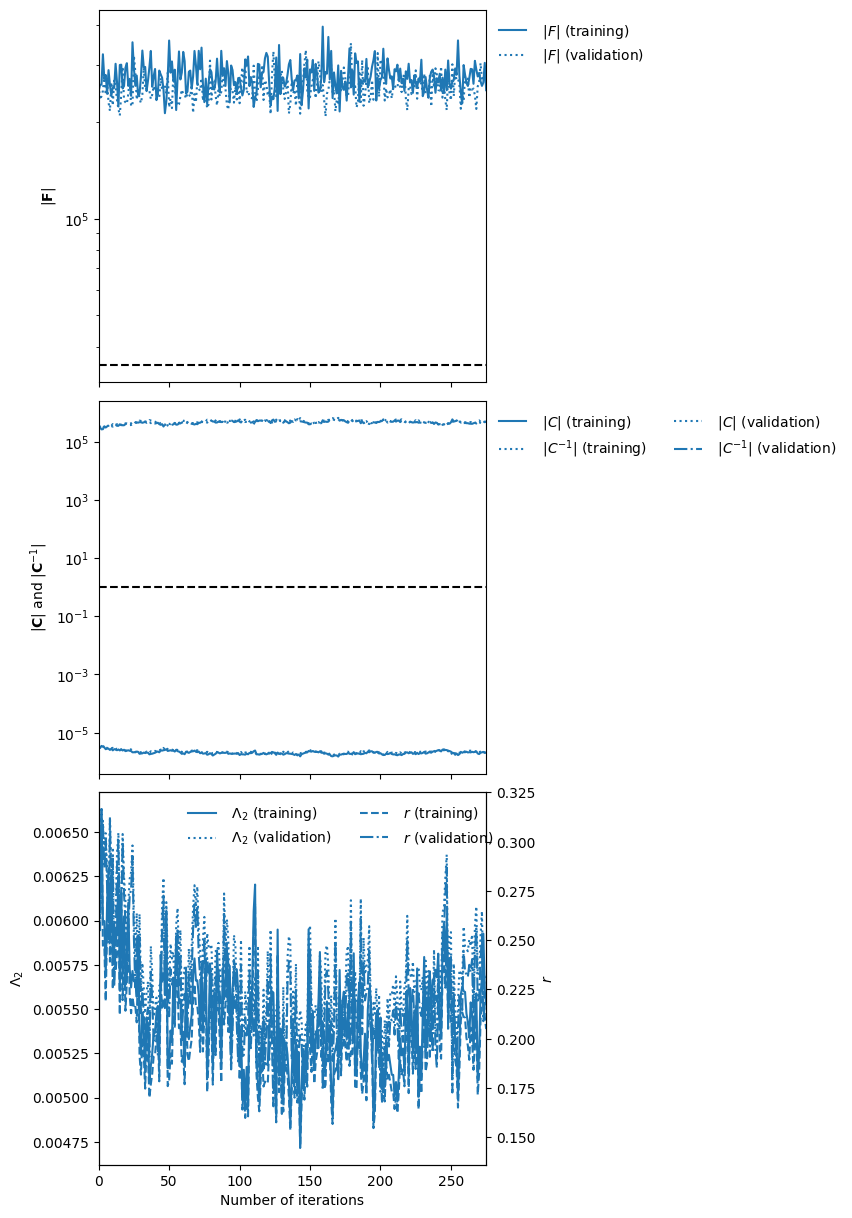

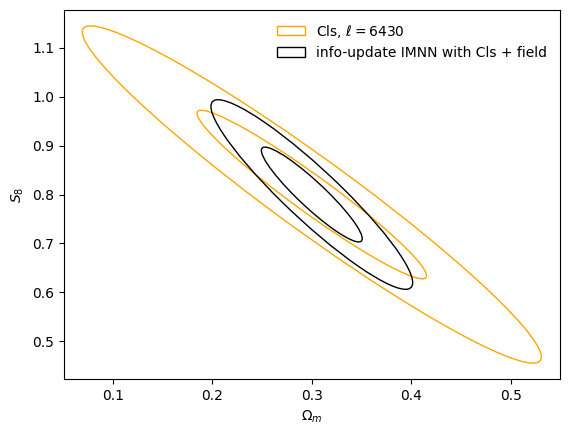

COMPRESSING PRIOR


100%|██████████| 500/500 [02:53<00:00,  2.89it/s]
2024-06-21 00:19:14.948877: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-21 00:19:15.542010: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593338614s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-21 00:1

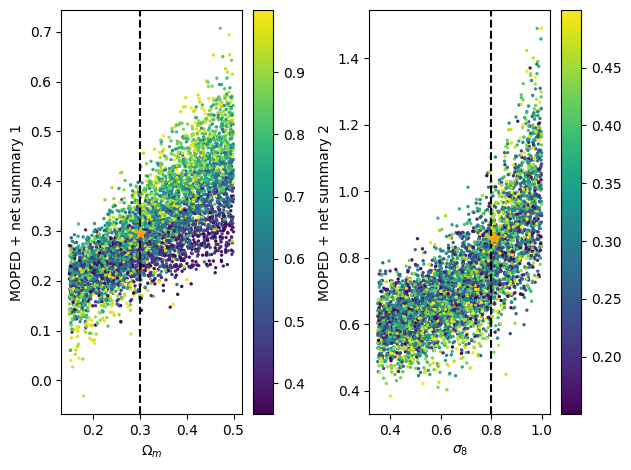

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.9
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.90, ELL_MIN=0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.02864449 0.03992733 0.04955164 0.05781572]


100%|██████████| 300/300 [00:24<00:00, 12.24it/s]


num trainable params:  6924
MOPED F:  [[953.4897  618.14844]
 [618.15173 431.8085 ]]
initial IMNN F:  [[2611.4556  1270.2292 ]
 [1270.2295   692.95325]]
initial det IMNN F:  196134.0
initial IMNN_F / MOPED_F : 6.6227016
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

2024-06-21 00:21:50.901738: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 14.78GiB (15867607752B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.78GiB
                 total allocation:   17.25GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/bo

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 14.78GiB (15867607752B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.78GiB
                 total allocation:   17.25GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]
		==========================

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/body/jit(body)/jit(<unnamed wrapped function>)/broadcast_in_dim[shape=(500, 2, 4, 192, 192) broadcast_dimensions=()]" source_file="/home/makinen/venvs/lemur/lib64/python3.11/site-packages/netket/jax/_scanmap.py" source_line=91
		XLA Label: fusion
		Shape: f32[500,2,4,192,192]
		==========================

	Buffer 7:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 8:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 9:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 10:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 11:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 12:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 13:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 14:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 15:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================



In [26]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.8*100)



noiseamps = [0.85, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

In [ ]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.75*100)



noiseamps = [0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.8
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.80, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02546177 0.03549096 0.0440459  0.05139175]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:22<00:00, 13.61it/s]


num trainable params:  6924
MOPED F:  [[1134.639    728.97955]
 [ 728.97906  505.39716]]
initial IMNN F:  [[2964.2183  1425.0896 ]
 [1425.0894   772.81506]]
initial det IMNN F:  259912.5
initial IMNN_F / MOPED_F : 6.1836076
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

-----------------------
RETRAINING FOR NOISEAMP:  0.75
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.75, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02387041 0.03327278 0.04129303 0.04817977]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:21<00:00, 13.69it/s]


num trainable params:  6924
MOPED F:  [[1252.8181   801.21   ]
 [ 801.21246  553.5833 ]]
initial IMNN F:  [[3136.3057 1507.2463]
 [1507.2463  832.0249]]
initial det IMNN F:  337693.0
initial IMNN_F / MOPED_F : 6.54447
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[1252.8181   801.21   ]
 [ 801.21246  553.5833 ]]
final IMNN F:  [[3375.5522  1615.3862 ]
 [1615.3862   878.76965]]
final IMNN_F / MOPED_F : 6.91593


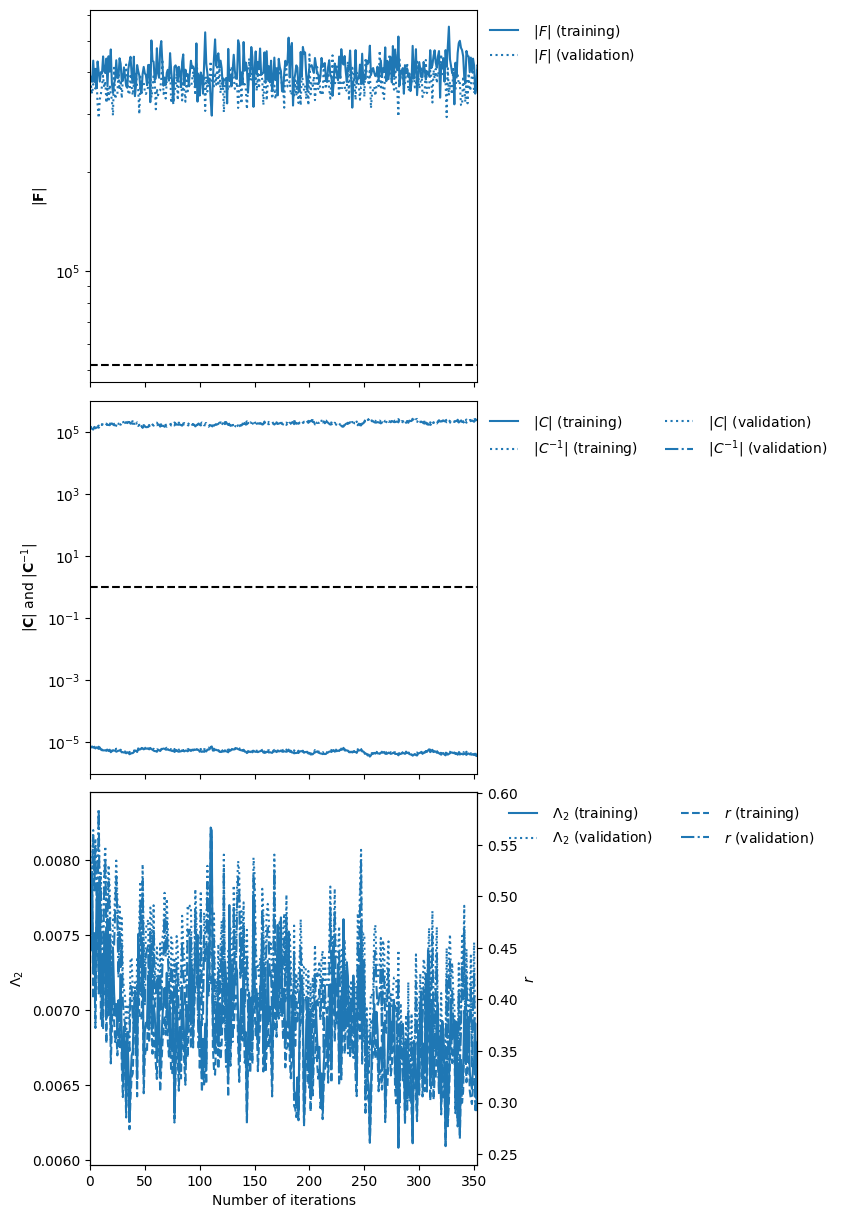

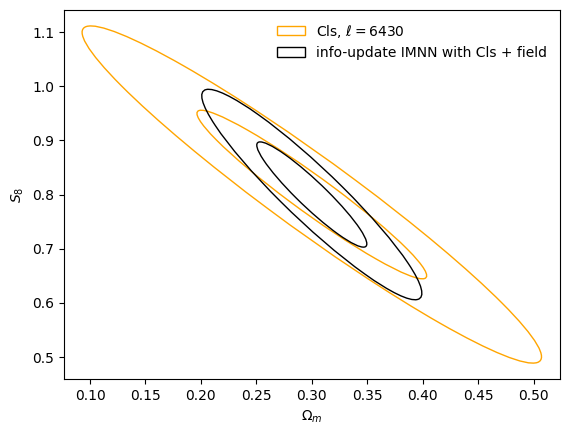

COMPRESSING PRIOR


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
2024-06-18 18:53:46.085806: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 18:53:46.679015: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593418003s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 18:5

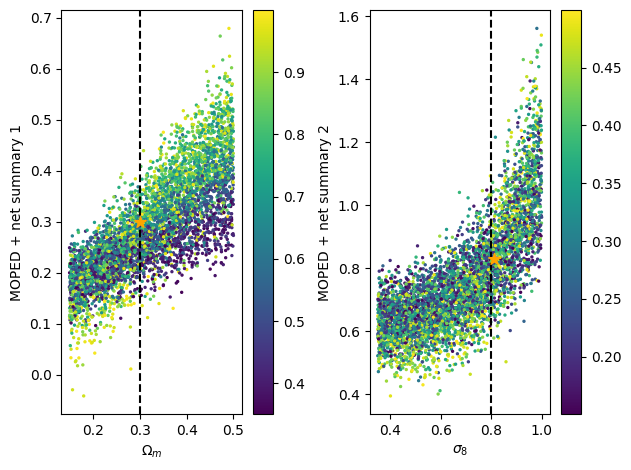

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.8
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.80, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.02546177 0.03549096 0.0440459  0.05139175]


100%|██████████| 300/300 [00:23<00:00, 12.72it/s]


num trainable params:  6924
MOPED F:  [[1134.6494   728.98627]
 [ 728.9888   505.4036 ]]
initial IMNN F:  [[3106.332  1471.9812]
 [1471.9814  794.0224]]
initial det IMNN F:  299768.25
initial IMNN_F / MOPED_F : 7.131725
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

2024-06-18 18:56:24.111585: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/bo

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]
		==========================

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/body/jit(body)/jit(<unnamed wrapped function>)/broadcast_in_dim[shape=(500, 2, 4, 192, 192) broadcast_dimensions=()]" source_file="/home/makinen/venvs/lemur/lib64/python3.11/site-packages/netket/jax/_scanmap.py" source_line=91
		XLA Label: fusion
		Shape: f32[500,2,4,192,192]
		==========================

	Buffer 7:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 8:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 9:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 10:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 11:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 12:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 13:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 14:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 15:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================



In [24]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.70*100)



noiseamps = [0.75, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.7
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.70, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02227905 0.03105459 0.03854016 0.04496778]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


num trainable params:  6924
MOPED F:  [[1395.5139  888.1738]
 [ 888.1726  611.6853]]
initial IMNN F:  [[3469.94   1631.689 ]
 [1631.689   880.1191]]
initial det IMNN F:  391551.25
initial IMNN_F / MOPED_F : 6.0458455
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[1395.5139  888.1738]
 [ 888.1726  611.6853]]
final IMNN F:  [[3684.806  1750.112 ]
 [1750.112   952.8195]]
final IMNN_F / MOPED_F : 6.9184256


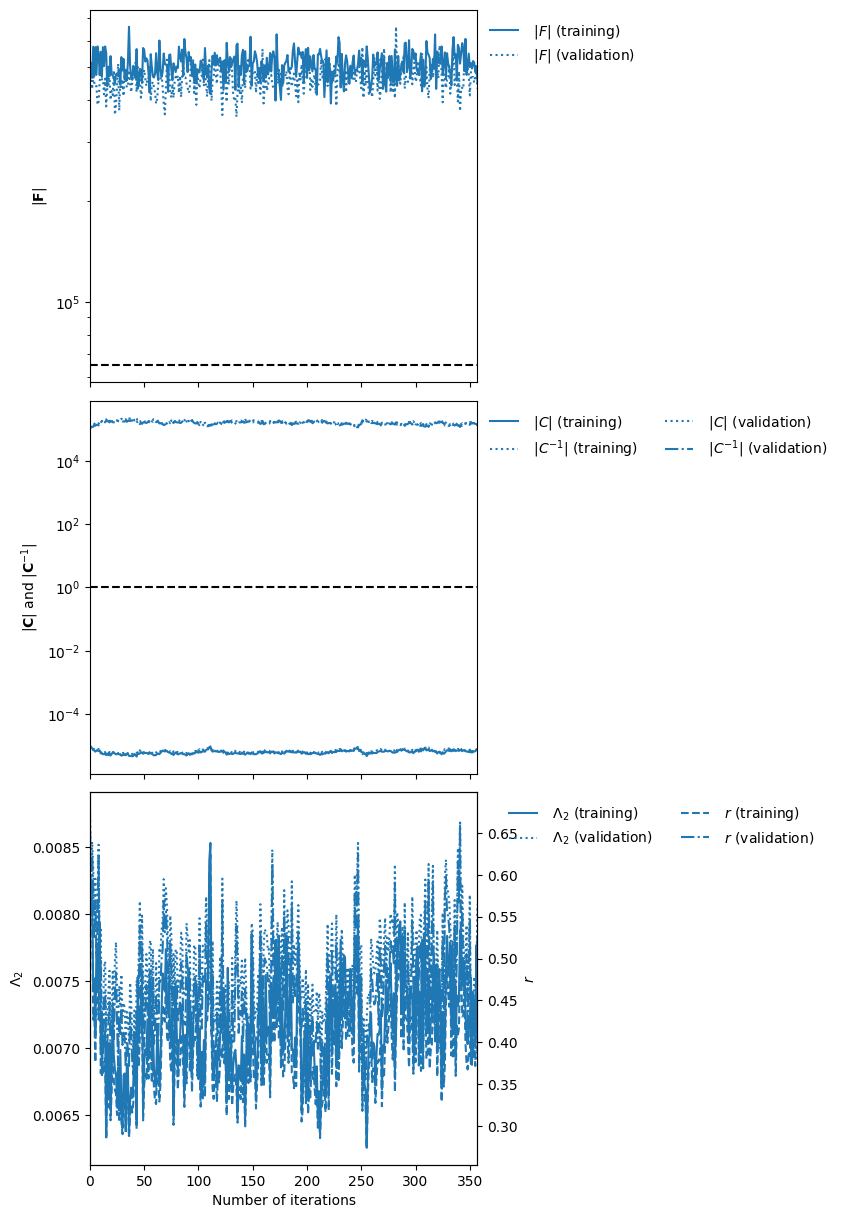

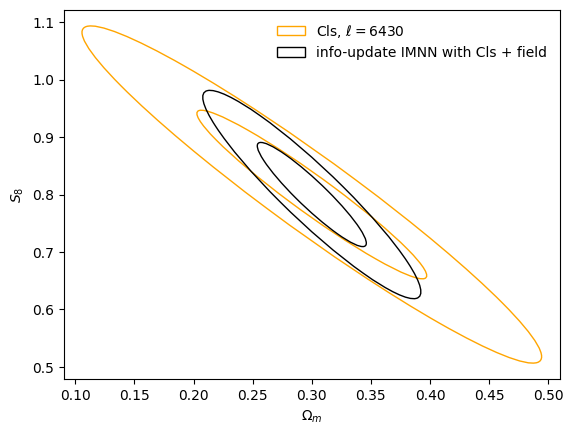

COMPRESSING PRIOR


100%|██████████| 500/500 [02:53<00:00,  2.88it/s]
2024-06-18 17:21:20.687127: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 17:21:21.280995: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.59407796s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 17:21

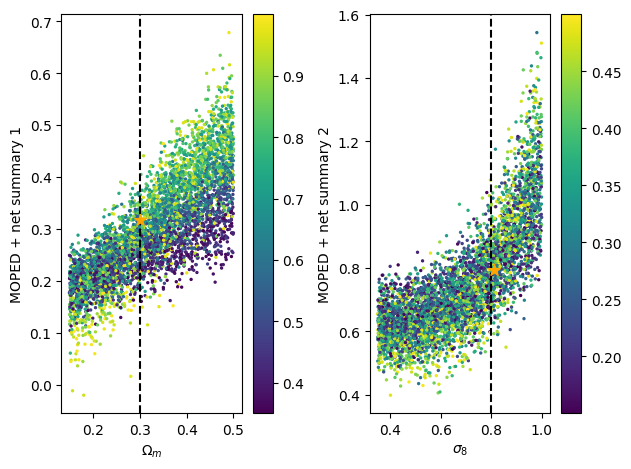

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.8
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.80, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.02546177 0.03549096 0.0440459  0.05139175]


100%|██████████| 300/300 [00:24<00:00, 12.07it/s]


num trainable params:  6924
MOPED F:  [[1134.6349   728.9763 ]
 [ 728.9706   505.39075]]
initial IMNN F:  [[2940.48   1438.2031]
 [1438.2031  787.7219]]
initial det IMNN F:  247852.25
initial IMNN_F / MOPED_F : 5.8967953
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

2024-06-18 17:23:57.500999: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/bo

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]
		==========================

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/body/jit(body)/jit(<unnamed wrapped function>)/broadcast_in_dim[shape=(500, 2, 4, 192, 192) broadcast_dimensions=()]" source_file="/home/makinen/venvs/lemur/lib64/python3.11/site-packages/netket/jax/_scanmap.py" source_line=91
		XLA Label: fusion
		Shape: f32[500,2,4,192,192]
		==========================

	Buffer 7:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 8:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 9:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 10:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 11:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 12:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 13:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 14:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 15:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================



In [26]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.65*100)



noiseamps = [0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.65
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.65, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.02068769 0.02883641 0.03578729 0.0417558 ]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:21<00:00, 14.00it/s]


num trainable params:  6924
MOPED F:  [[1567.8994   992.72095]
 [ 992.72656  681.6249 ]]
initial IMNN F:  [[3854.4492 1728.7742]
 [1728.7742  929.9148]]
initial det IMNN F:  595649.0
initial IMNN_F / MOPED_F : 7.1576242
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[1567.8994   992.72095]
 [ 992.72656  681.6249 ]]
final IMNN F:  [[3909.1978 1852.0417]
 [1852.0417 1011.3849]]
final IMNN_F / MOPED_F : 6.292384


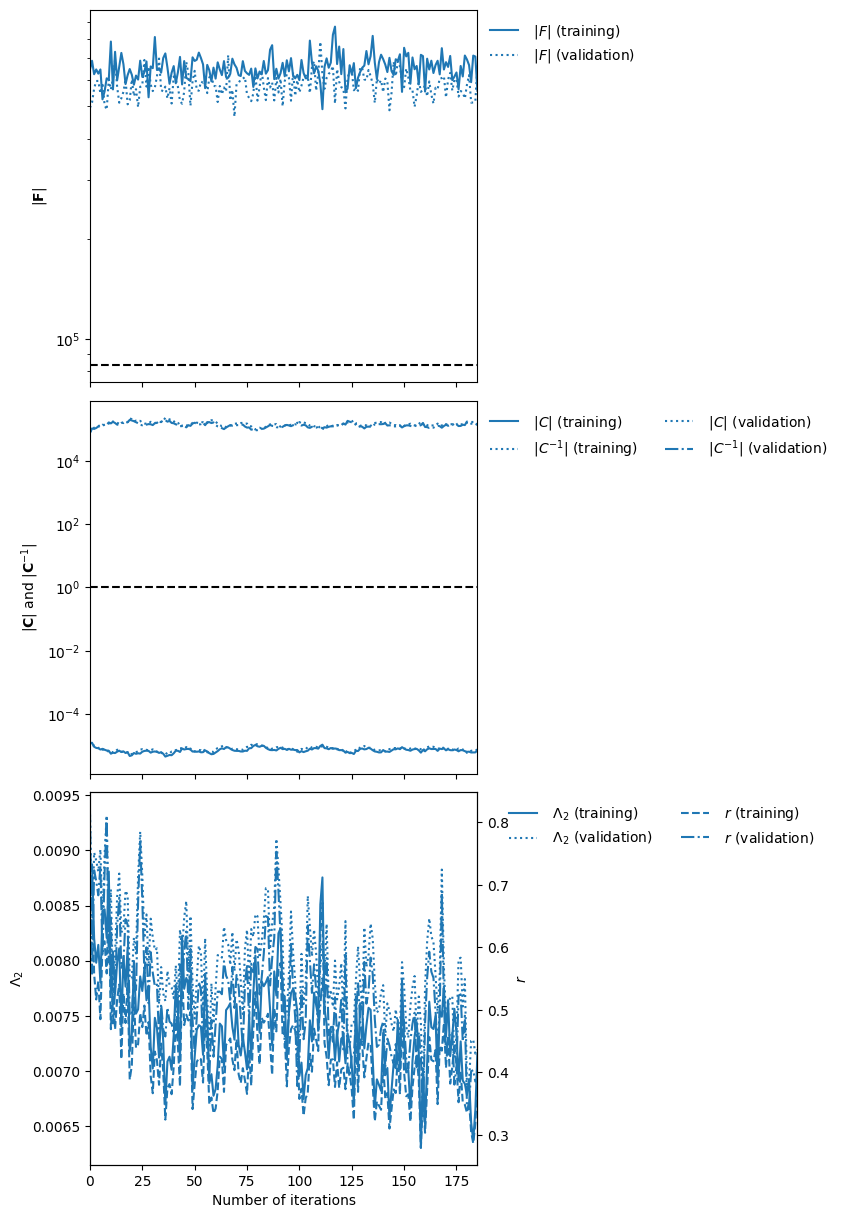

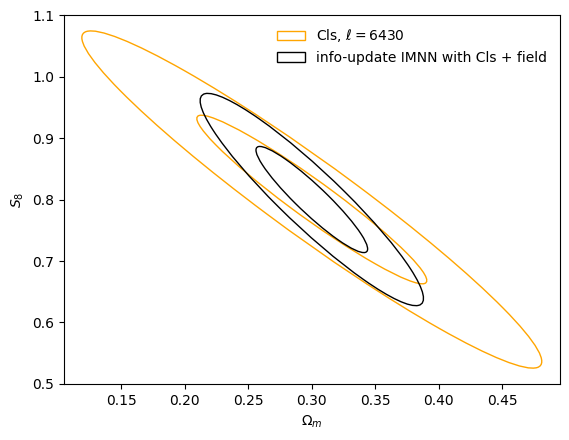

COMPRESSING PRIOR


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
2024-06-12 20:04:40.945068: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-12 20:04:41.538230: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593338499s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-12 20:0

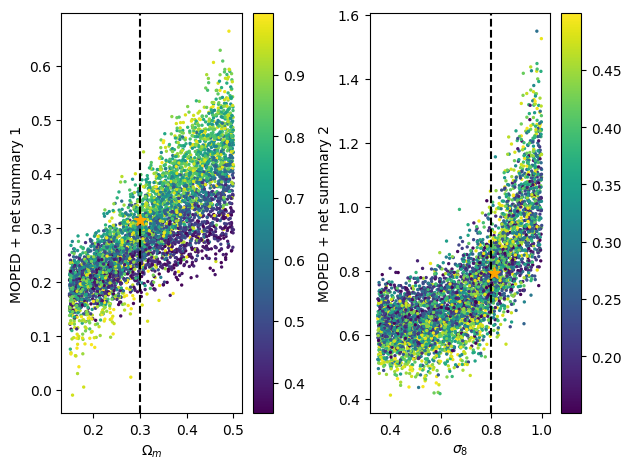

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.7
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.70, ELL_MIN=0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.02227905 0.03105459 0.03854016 0.04496778]


100%|██████████| 300/300 [00:22<00:00, 13.06it/s]


num trainable params:  6924
MOPED F:  [[1395.5059   888.1691 ]
 [ 888.1699   611.68506]]
initial IMNN F:  [[3551.0623 1682.492 ]
 [1682.4921  902.8435]]
initial det IMNN F:  375274.25
initial IMNN_F / MOPED_F : 5.7944045
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

2024-06-12 20:07:13.144737: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/bo

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 14.80GiB (15889770824B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   381.6KiB
              constant allocation:    2.48GiB
        maybe_live_out allocation:   383.5KiB
     preallocated temp allocation:   14.80GiB
                 total allocation:   17.28GiB
Peak buffers:
	Buffer 1:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 2:
		Size: 852.56MiB
		XLA Label: fusion
		Shape: f32[500,2,193,193,6]
		==========================

	Buffer 3:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[375,2,2,4,192,192]
		==========================

	Buffer 4:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 5:
		Size: 843.75MiB
		XLA Label: constant
		Shape: f32[1500,4,192,192]
		==========================

	Buffer 6:
		Size: 562.50MiB
		Operator: op_name="jit(while)/jit(main)/while/body/jit(body)/jit(<unnamed wrapped function>)/broadcast_in_dim[shape=(500, 2, 4, 192, 192) broadcast_dimensions=()]" source_file="/home/makinen/venvs/lemur/lib64/python3.11/site-packages/netket/jax/_scanmap.py" source_line=91
		XLA Label: fusion
		Shape: f32[500,2,4,192,192]
		==========================

	Buffer 7:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 8:
		Size: 476.26MiB
		XLA Label: fusion
		Shape: bf16[500,2,204,204,6]
		==========================

	Buffer 9:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 10:
		Size: 426.28MiB
		XLA Label: fusion
		Shape: bf16[500,2,193,193,6]
		==========================

	Buffer 11:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 12:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 13:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 14:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================

	Buffer 15:
		Size: 421.88MiB
		XLA Label: fusion
		Shape: bf16[500,2,192,192,6]
		==========================



In [26]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
# weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.60*100)


noiseamps = [0.65, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.6
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.60, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.01909633 0.02661822 0.03303443 0.03854381]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:24<00:00, 12.27it/s]


num trainable params:  6924
MOPED F:  [[1775.3643 1117.4768]
 [1117.48    765.0553]]
initial IMNN F:  [[4123.193  1903.6797]
 [1903.6797 1038.1406]]
initial det IMNN F:  656457.75
initial IMNN_F / MOPED_F : 5.9953833
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[1775.3643 1117.4768]
 [1117.48    765.0553]]
final IMNN F:  [[4337.892  2012.1394]
 [2012.1394 1107.5525]]
final IMNN_F / MOPED_F : 6.902103


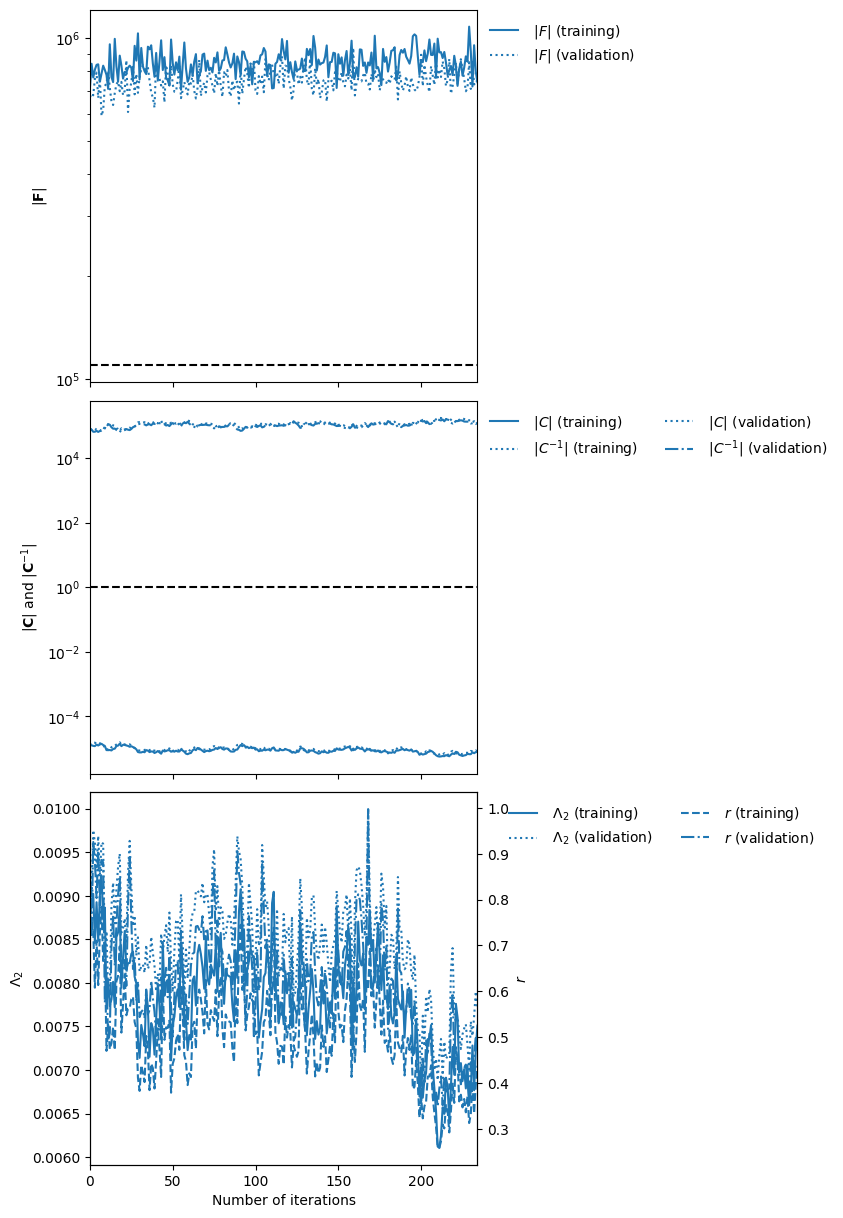

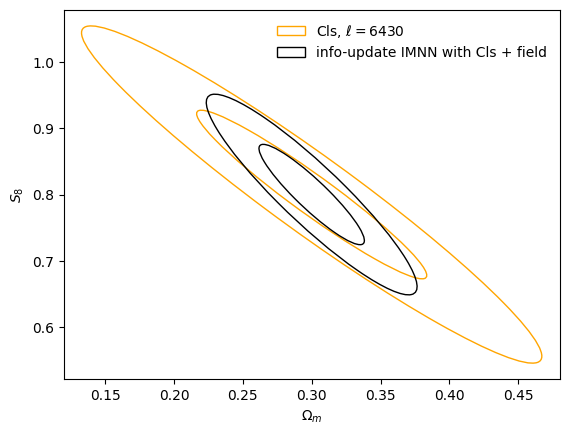

COMPRESSING PRIOR


100%|██████████| 500/500 [02:58<00:00,  2.79it/s]
2024-06-11 19:01:53.224186: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 19:01:53.817409: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593430861s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 19:0

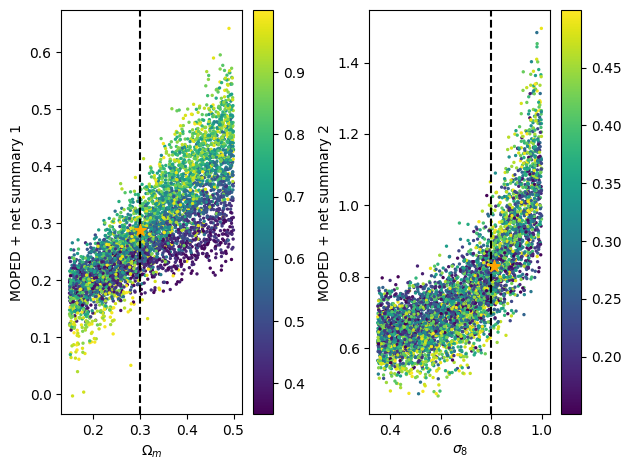

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.7
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.70, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.02227905 0.03105459 0.03854016 0.04496778]


100%|██████████| 300/300 [00:26<00:00, 11.50it/s]


num trainable params:  6924
MOPED F:  [[1395.5082   888.16907]
 [ 888.1674   611.6813 ]]
initial IMNN F:  [[3566.2922 1638.8613]
 [1638.8613  872.3955]]
initial det IMNN F:  425350.75
initial IMNN_F / MOPED_F : 6.567761
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MemoryError: std::bad_alloc

In [24]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.55*100)


noiseamps = [0.6, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.55
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.55, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.01750497 0.02440004 0.03028156 0.03533183]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:25<00:00, 11.96it/s]


num trainable params:  6924
MOPED F:  [[2022.9426  1264.384  ]
 [1264.3772   863.14087]]
initial IMNN F:  [[4448.083  1976.4479]
 [1976.4478 1086.627 ]]
initial det IMNN F:  927061.0
initial IMNN_F / MOPED_F : 6.2883086
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[2022.9426  1264.384  ]
 [1264.3772   863.14087]]
final IMNN F:  [[4716.1284 2105.8352]
 [2105.8354 1168.198 ]]
final IMNN_F / MOPED_F : 7.2906313


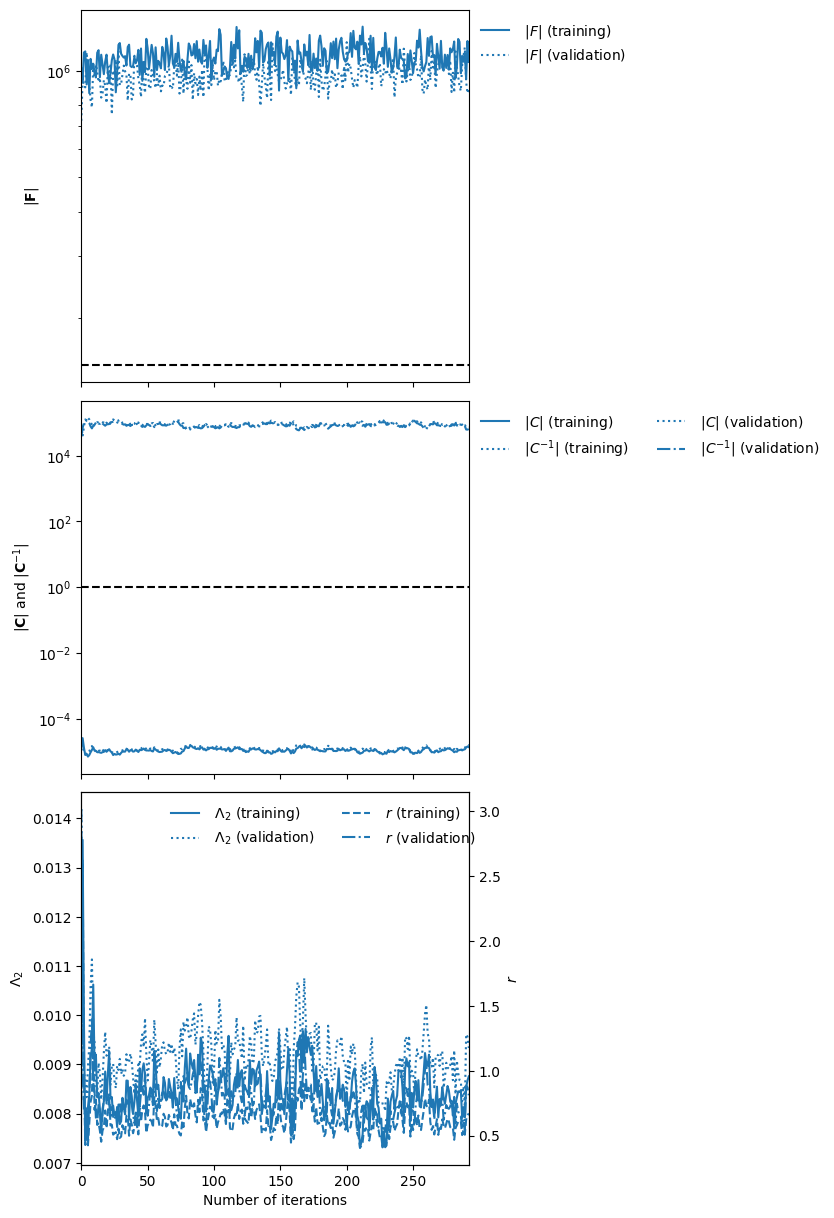

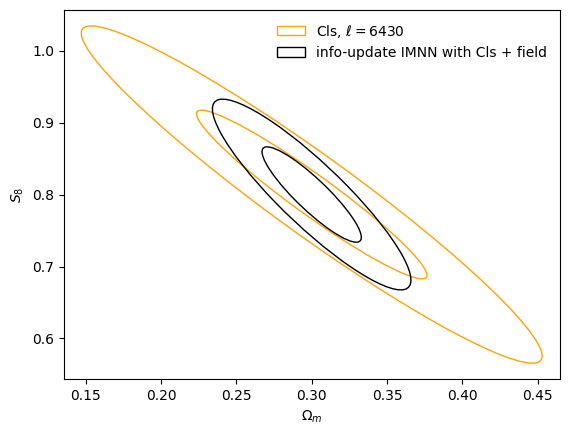

COMPRESSING PRIOR


100%|██████████| 500/500 [02:59<00:00,  2.78it/s]
2024-06-11 13:05:51.633256: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 13:05:52.226790: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593746183s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 13:0

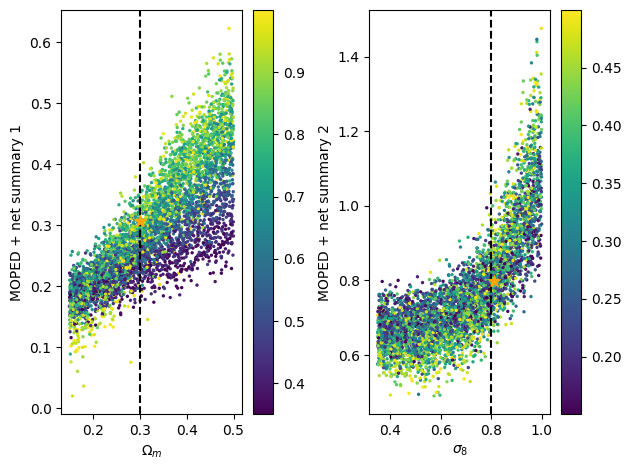

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.6
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.60, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.01909633 0.02661822 0.03303443 0.03854381]


100%|██████████| 300/300 [00:27<00:00, 10.75it/s]


num trainable params:  6924
MOPED F:  [[1775.3646  1117.478  ]
 [1117.491    765.06274]]
initial IMNN F:  [[4233.508  1907.7083]
 [1907.7083 1016.7657]]
initial det IMNN F:  665134.75
initial IMNN_F / MOPED_F : 6.0746365
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MemoryError: std::bad_alloc

In [25]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.50*100)


noiseamps = [0.55, 0.6, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.5
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.50, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.01591361 0.02218185 0.02752869 0.03211984]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:24<00:00, 12.19it/s]


num trainable params:  6924
MOPED F:  [[2313.556  1433.6238]
 [1433.6294  975.8207]]
initial IMNN F:  [[4839.672  2182.75  ]
 [2182.7498 1206.2499]]
initial det IMNN F:  1073456.5
initial IMNN_F / MOPED_F : 5.3054605
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[2313.556  1433.6238]
 [1433.6294  975.8207]]
final IMNN F:  [[5194.866  2275.4895]
 [2275.4895 1269.1984]]
final IMNN_F / MOPED_F : 6.995796


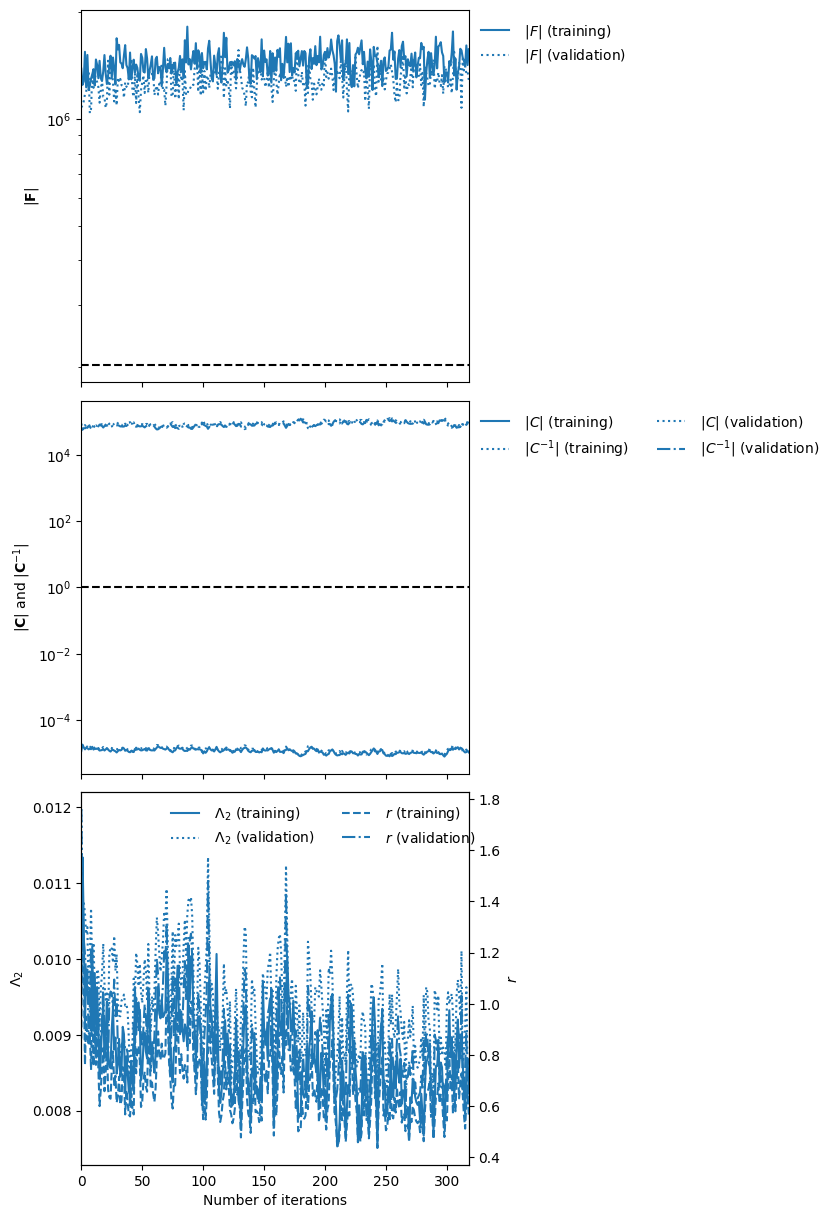

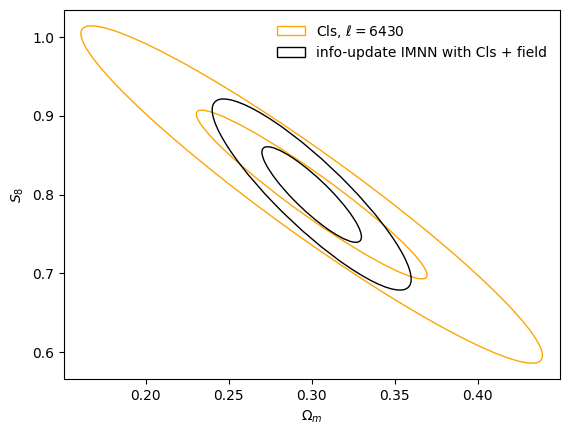

COMPRESSING PRIOR


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]
2024-06-11 12:14:44.947621: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 12:14:45.541115: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593727952s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 12:1

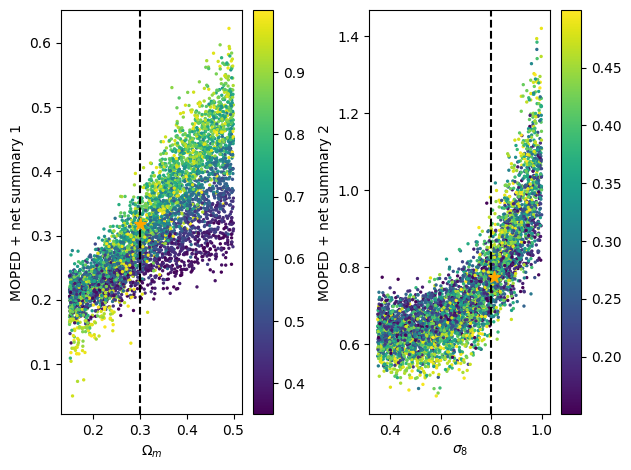

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.6
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.60, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.01909633 0.02661822 0.03303443 0.03854381]


100%|██████████| 300/300 [00:26<00:00, 11.47it/s]


num trainable params:  6924
MOPED F:  [[1775.3657 1117.4778]
 [1117.4819  765.0564]]
initial IMNN F:  [[4115.1045 1870.079 ]
 [1870.0789 1001.4882]]
initial det IMNN F:  624033.5
initial IMNN_F / MOPED_F : 5.699268
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MemoryError: std::bad_alloc

In [24]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.45*100)

noiseamps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)

-----------------------
RETRAINING FOR NOISEAMP:  0.45
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.45, ELL_MIN=0
MINIMUM ELL IDX:  0
NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


SCALED NOISE SIGMAS [0.01432224 0.01996367 0.02477582 0.02890786]


  0%|          | 0/300 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 300/300 [00:24<00:00, 12.11it/s]


num trainable params:  6924
MOPED F:  [[2647.0574 1622.9335]
 [1622.9271 1101.4202]]
initial IMNN F:  [[5562.133  2340.4736]
 [2340.4736 1308.6083]]
initial det IMNN F:  1800836.0
initial IMNN_F / MOPED_F : 6.3945713
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MOPED F:  [[2647.0574 1622.9335]
 [1622.9271 1101.4202]]
final IMNN F:  [[5506.0176 2392.996 ]
 [2392.996  1356.8883]]
final IMNN_F / MOPED_F : 6.1949563


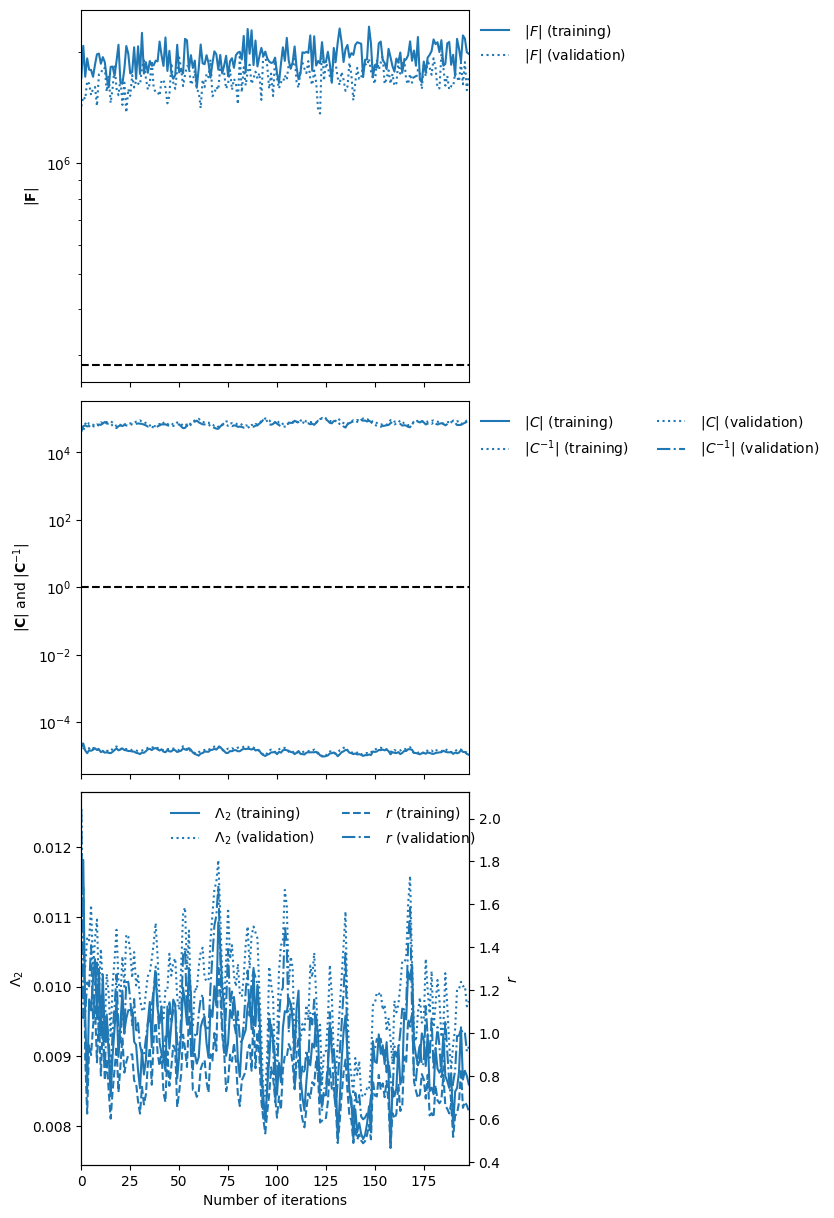

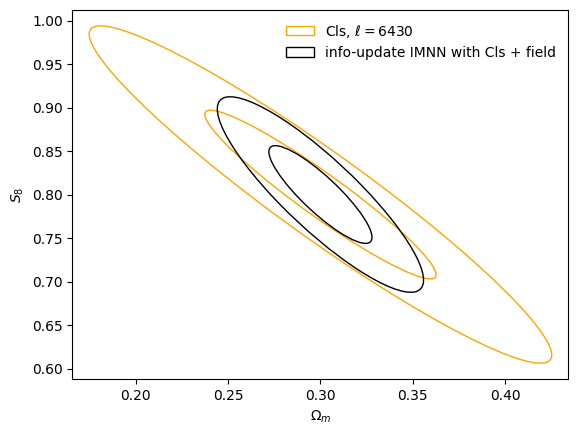

COMPRESSING PRIOR


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]
2024-06-11 11:13:11.049735: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 11:13:11.643312: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.593798693s
Trying algorithm eng28{k2=1,k3=0} for conv (f32[500,6,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,4,204,204]{3,2,1,0}, f32[6,4,13,13]{3,2,1,0}), window={size=13x13}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 11:1

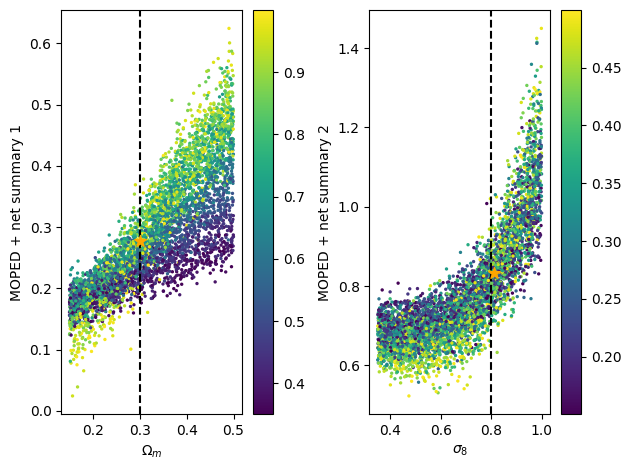

saving everything
-----------------------
RETRAINING FOR NOISEAMP:  0.5
-----------------------
COMPUTING MOPED COMPRESSION FOR N=192, NOISEAMP=0.50, ELL_MIN=0
MINIMUM ELL IDX:  0


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


NOISEVARS [0.00101297 0.00196814 0.00303132 0.00412674]
SCALED NOISE SIGMAS [0.01591361 0.02218185 0.02752869 0.03211984]


100%|██████████| 300/300 [00:26<00:00, 11.14it/s]


num trainable params:  6924
MOPED F:  [[2313.6067 1433.6575]
 [1433.6833  975.8572]]
initial IMNN F:  [[4822.3423 2160.6968]
 [2160.6968 1191.0463]]
initial det IMNN F:  1075022.5
initial IMNN_F / MOPED_F : 5.31298
training IMNN now


  0%|          | 0/7000 [00:00<?, ?it/s]

MemoryError: std::bad_alloc

In [24]:
# write a loop to slowly increase noise
from fisherplot import *
import gc
gc.collect()

weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
#weightfile = "imnn_w_N_%d_allell_2outs.pkl"%(N)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.15*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.20*100)
#weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.30*100)
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, 0.40*100)

noiseamps = [0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#weightfile = "imnn_w_N_%d_2out_noise_%d"%(N, noiseamp*100)

# start off the keys
model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)

for j,noiseamp in enumerate(noiseamps): 
    key,rng = jr.split(key)
    weightfile = run_training(key, noiseamp, weightdir, weightfile)



In [27]:
weightfile

'imnn_w_N_192_2out_noise_15.pkl'

In [26]:
IMNN.F, mymoped.F # detF 4680780

(Array([[11705.809 ,  3621.488 ],
        [ 3621.4875,  2435.8667]], dtype=float32),
 Array([[5425.809 , 2822.9417],
        [2822.8984, 2259.1328]], dtype=float32))

In [396]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(IMNN.w))

In [397]:
param_count

41031

In [399]:
128*128*4

65536

In [ ]:
from fisherplot import *

key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


def compress_prior(key, noiseamp, weightdir, weightfile, smallprior=True):
    
    NOISEAMP = noiseamp
    print("-----------------------")
    print("COMPRESSING FOR NOISEAMP: ", noiseamp)
    print("-----------------------")
    
    # --- IMNN STUFF
    # Clip gradients at max value, and evt. apply weight decay
    transf = [optax.clip(1.0)]
    transf.append(optax.add_decayed_weights(1e-4))
    optimiser = optax.chain(
        *transf,
        #optax.sgd(learning_rate=5e-4, momentum=0.9)
        optax.adam(learning_rate=5e-4)
    )
    
    # ---
    
    # insatiate new moped statistic with higher noise settings
    mymoped, moped_stat, noisevars = get_moped_and_summaries(N=192, noiseamp=NOISEAMP, n_gal=30.)

    # initialise model
    model_key = jr.PRNGKey(44)
    model = MDN_net_stacked(filters=[3,3,3],
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        moped=mymoped,
                        act=almost_leaky, 
                        n_outs=2,
                        dtype=jnp.bfloat16
    )

    def noise_simulator_dict(sim, noisescale=noiseamp, rot=True, noisevars=noisevars):
        key = sim["key"] # assigned in IMNN scheme
        sim = sim["data"]
        key1,key2 = jr.split(key)
        # do rotations of simulations
        k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
        if rot:
         sim = rotate_sim(k, sim)
        else:
         sim = sim
        # now add noise
        # this generates white noise across all pixels and then increases the amplitude
        sim = sim.at[...].add(jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
        return sim


    num_bins = 6
    cl_shape = indices.shape[0]*num_bins

    np = jnp
    # initialise imnn
    n_s_eff = 1000
    n_d_eff = 250 
    gc.collect()
    IMNN =  newNoiseNumericalGradientIMNN(
        n_s=n_s_eff, n_d=n_d_eff, n_params=n_params, n_summaries=2 + 2,
        input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
        optimiser=optimiser, key_or_state=jnp.array(model_key),
        noise_simulator=partial(noise_simulator_dict, 
                                noisescale=NOISEAMP, rot=True),
        chunk_size=2,
        fiducial=outdir + "val_fid.npy", #jnp.load(outdir + "val_fid.npy")[:n_s_eff], #  #
        derivative=outdir + "val_derv.npy",  #jnp.load(outdir + "val_derv.npy")[:n_d_eff], #  
        validation_fiducial=outdir + "fid.npy", #jnp.load(outdir + "fid.npy")[:n_s_eff], # 
        validation_derivative=outdir + "val_derv.npy", #jnp.load(outdir + "derv.npy")[:n_d_eff], #  
        #existing_statistic=None,
        existing_statistic=moped_stat,
        no_invC=True, # True
        evidence=True
    )
    gc.collect()
    # load the previous round's weights
    wbest = load_obj(weightdir + weightfile)
    print("num trainable params: ", sum(x.size for x in jax.tree_util.tree_leaves(wbest)))
    
    IMNN.set_F_statistics(wbest, key)
    print("MOPED F: ", mymoped.F)
    print("initial IMNN F: ", IMNN.F)
    print("initial det IMNN F: ", np.linalg.det(IMNN.F))
    print("initial IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    print("training IMNN now")
    key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 

    # print and show fishers
    print("MOPED F: ", mymoped.F)
    print("final IMNN F: ", IMNN.F)
    print("final IMNN_F / MOPED_F :", jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)) 

    # -----
    # make a fisher plot
    mean = θ_fid
    fishers = [mymoped.F, IMNN.F]
    colours =["orange", "black", "blue"]
    labels = [r"Cls, $\ell=%d$"%(6430),  "info-update IMNN with Cls + field"]
    
    for i,f in enumerate(fishers): 
        if i==0:
            ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
        else:
            plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])
    
    plt.legend(framealpha=0.0)
    plt.xlabel(r'$\Omega_m$')
    plt.ylabel(r'$S_8$')
    plt.show()
    # -----

    
    print("COMPRESSING PRIOR")
    # pull in all the prior simulations
    if smallprior:
        prior_sims = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/smaller_prior_sims.npz")["prior_sims"]
        prior_theta = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/smaller_prior_sims.npz")["prior_theta"]

    else:
        prior_sims = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/prior_sims.npz")["prior_sims"]
        prior_theta = jnp.load("/data101/makinen/lemur_sims/pm_sims/N192_hires/prior_sims.npz")["prior_theta"]
    
    def get_sigma8(omegam, S8):
        return S8 / (jnp.sqrt(omegam / 0.3))
    
    def get_S8(theta):
        return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

    
    key = jr.PRNGKey(333)
    noisekeys = jr.split(key, num=prior_sims.shape[0])
    # add in noise
    def _assign_keys(key, data):
        return dict(key=key,
                    data=data)
        
    prior_sims = jax.vmap(_assign_keys)(noisekeys, prior_sims)
    prior_sims = nk.jax.vmap_chunked(noise_simulator_dict, chunk_size=2)(prior_sims)
    
    # now compute Cls 
    prior_cls = []
    batch = 10
    for i in tq(range(prior_sims.shape[0] // batch)):
        f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
        prior_cls.append(f_)
    
    prior_cls = jnp.concatenate(prior_cls)
    # compress with moped to get Cls summaries
    moped_summaries = mymoped.compress(prior_cls)

    # get IMNN to compress
    batch = 100
    outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in tq(range(prior_sims.shape[0] // batch))])

    # load target
    target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
    target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]
    
    noise_target_key = jax.random.PRNGKey(604)
    noisy_target = noise_simulator(noise_target_key, target, rot=True, noisevars=noisevars, noisescale=noiseamp)
    network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])
    moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

    # plot summaries
    plt.subplot(121)
    im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
    plt.axvline(θ_fid[0], c="k", ls="--")
    plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)
    
    plt.xlabel(r"$\Omega_m$")
    plt.ylabel(r"MOPED + net summary 1")
    plt.colorbar(im)
    
    plt.subplot(122)
    im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
    plt.axvline(θ_fid[1], c="k", ls="--")
    plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
    plt.ylabel(r"MOPED + net summary 2")
    plt.xlabel(r"$\sigma_8$")
    plt.colorbar(im)
    plt.tight_layout()

    plt.show()
    
    print("saving everything")

    if smallprior:
        fname = "N192_noisy/summaries_noise_%d"%(noiseamp * 100)
    else:
        fname = "N192_noisy/summaries_noise_%d_bigprior"%(noiseamp * 100)
    
    np.savez(fname,
             moped_summaries=moped_summaries,
             prior_theta=prior_theta,
             network_outputs=outputs,
             target=target,
             noisy_target=noisy_target,
             target_theta=target_theta,
             network_target=network_target,
             moped_target=moped_target
            )
    gc.collect()

In [ ]:
import gc
from fisherplot import *
gc.collect()

noiseamp = 0.9

outdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/"
weightdir = "/data101/makinen/lemur_sims/pm_sims/N192_hires/noise_comparison/"
weightfile = "imnn_w_N_%d_2out_noise_%d.pkl"%(N, noiseamp*100)

compress_prior(key, noiseamp, weightdir, weightfile, smallprior=False)